<a href="https://colab.research.google.com/github/DajanaSanchez/BirdMigrationClimateAnalysis/blob/main/Captone_Bird_20250130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/IT Capstone'

%ls -ltra


/content/drive/MyDrive/Colab Notebooks/IT Capstone
total 26452941
-rw------- 1 root root  1506197081 Jan 29 01:46 ebd_US_rthhum_197401_202412_smp_relDec-2024.txt
-rw------- 1 root root 20683108218 Jan 29 02:09 ebd_US_rthhum_197401_202412_smp_relDec-2024_sampling.txt
-rw------- 1 root root        6171 Jan 29 03:27 robert.dat
-rw------- 1 root root  4664523745 Jan 30 02:59 checklists_big.parquet
-rw------- 1 root root   233975123 Jan 30 03:09 checklists.parquet


In [3]:
dtype_dict = {
    'GLOBAL UNIQUE IDENTIFIER': 'str',
    'TAXONOMIC ORDER': 'str',
    'CATEGORY': 'str',
    'TAXON CONCEPT ID': 'str',
    'COMMON NAME': 'str',
    'SCIENTIFIC NAME': 'str',
    'SUBSPECIES COMMON NAME': 'str',
    'SUBSPECIES SCIENTIFIC NAME': 'str',
    'EXOTIC CODE': 'str',
    'OBSERVATION COUNT': 'str',
    'BREEDING CODE': 'str',
    'BREEDING CATEGORY': 'str',
    'BEHAVIOR CODE': 'str',
    'AGE/SEX': 'str',
    'COUNTRY': 'str',
    'COUNTRY CODE': 'str',
    'STATE': 'str',
    'STATE CODE': 'str',
    'COUNTY': 'str',
    'COUNTY CODE': 'str',
    'IBA CODE': 'str',
    'BCR CODE': 'str',
    'USFWS CODE': 'str',
    'ATLAS BLOCK': 'str',
    'LOCALITY': 'str',
    'LOCALITY ID': 'str',
    'LOCALITY TYPE': 'str',
    'LATITUDE': 'str',
    'LONGITUDE': 'str',
    'OBSERVATION DATE': 'str',
    'TIME OBSERVATIONS STARTED': 'str',
    'OBSERVER ID': 'str',
    'SAMPLING EVENT IDENTIFIER': 'str',
    'PROTOCOL TYPE': 'str',
    'PROTOCOL CODE': 'str',
    'PROJECT CODE': 'str',
    'DURATION MINUTES': 'str',
    'EFFORT DISTANCE KM': 'str',
    'EFFORT AREA HA': 'str',
    'NUMBER OBSERVERS': 'str',
    'ALL SPECIES REPORTED': 'str',
    'GROUP IDENTIFIER': 'str',
    'HAS MEDIA': 'str',
    'APPROVED': 'str',
    'REVIEWED': 'str',
    'REASON': 'str',
    'TRIP COMMENTS': 'str',
    'SPECIES COMMENTS': 'str'
}

In [ ]:
!pip install geopandas
!pip install pandas
!pip install matplotlib
!pip install datetime
!pip install geopandas
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 8.5 MB/s eta 0:00:00


In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

# Define the file path
f_sed = "robert.dat"
#f_sed = "ebd_US_rthhum_197401_202412_smp_relDec-2024.txt"
#f_sed = "ebd_US_rthhum_197401_202412_smp_relDec-2024_sampling.txt"

# Read the eBird sampling file (tab-delimited)
checklists = pd.read_csv(
    f_sed
    ,sep='\t'
    ,low_memory=False
    ,on_bad_lines='warn'  # Print a warning for bad lines
    #,error_bad_lines=False  # Skip bad lines with incorrect number of fields
)

# Display structure of the data
print(checklists.info())  # Equivalent to glimpse() in R
print(checklists.head())  # Show first few rows

# Define the output Parquet file path
output_file = "checklists.parquet"

# Write the DataFrame to a Parquet file
checklists.to_parquet(output_file, engine='pyarrow', index=False)

# Confirm the file was written
print(f"Parquet file saved as {output_file}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GLOBAL UNIQUE IDENTIFIER    9 non-null      object 
 1   LAST EDITED DATE            9 non-null      object 
 2   TAXONOMIC ORDER             9 non-null      int64  
 3   CATEGORY                    9 non-null      object 
 4   TAXON CONCEPT ID            9 non-null      object 
 5   COMMON NAME                 9 non-null      object 
 6   SCIENTIFIC NAME             9 non-null      object 
 7   SUBSPECIES COMMON NAME      0 non-null      float64
 8   SUBSPECIES SCIENTIFIC NAME  0 non-null      float64
 9   EXOTIC CODE                 0 non-null      float64
 10  OBSERVATION COUNT           9 non-null      object 
 11  BREEDING CODE               0 non-null      float64
 12  BREEDING CATEGORY           0 non-null      float64
 13  BEHAVIOR CODE               0 non-null 

In [18]:
# Identify the date column (replace 'DATE_COLUMN' with the actual column name)
date_column = 'OBSERVATION DATE'  # Update with the correct column name

# Convert to datetime
checklists[date_column] = pd.to_datetime(checklists[date_column], errors='coerce')

# Find the oldest and newest date
oldest_date = checklists[date_column].min()
newest_date = checklists[date_column].max()

print(f"Oldest date: {oldest_date}")
print(f"Newest date: {newest_date}")

# Find the most common date
most_common_date = checklists[date_column].mode()[0]

# Count occurrences of the most common date
most_common_date_count = (checklists[date_column] == most_common_date).sum()

# Get total record count
total_records = len(checklists)

print(f"Most common date: {most_common_date} (occurs {most_common_date_count} times)")
print(f"Total record count: {total_records}")




Oldest date: 1974-01-01 00:00:00
Newest date: 2024-12-31 00:00:00
Most common date: 2024-05-11 00:00:00 (occurs 104873 times)
Total record count: 82639904


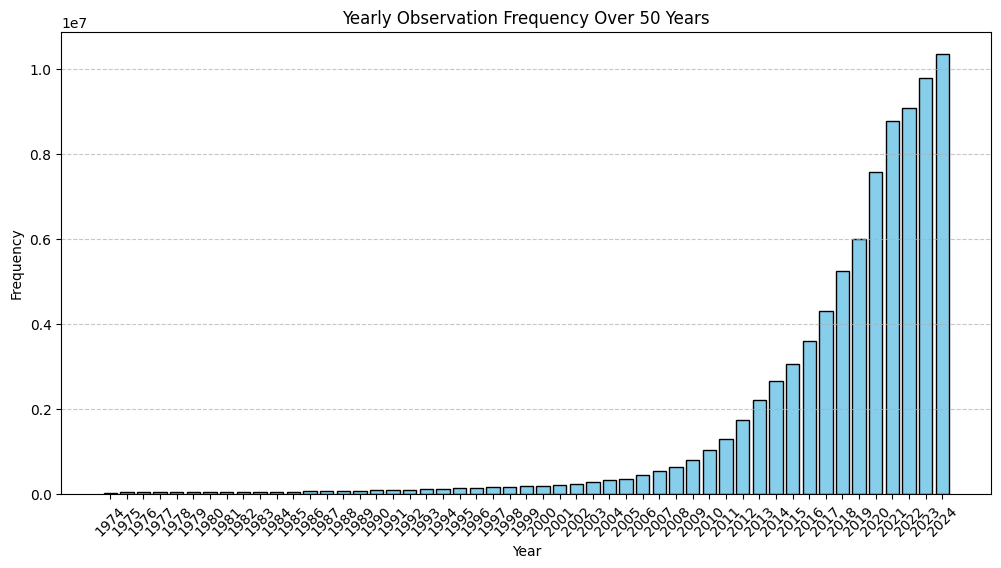

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Drop NaN values in the date column
checklists = checklists.dropna(subset=[date_column])

# Group by year and count occurrences
checklists['Year'] = checklists[date_column].dt.year
yearly_counts = checklists['Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts.index.astype(str), yearly_counts.values, color='skyblue', edgecolor='black')

# Formatting
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Yearly Observation Frequency Over 50 Years')
plt.xticks(rotation=45)  # Slight rotation for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()



In [ ]:
# Define the Google Drive path
output_file = "/content/drive/MyDrive/Colab Notebooks/IT Capstone/checklists_big.parquet"

# Write the DataFrame to a Parquet file
checklists.to_parquet(output_file, engine='pyarrow', index=False)

print(f"Parquet file saved at: {output_file}")


Parquet file saved at: /content/drive/MyDrive/Colab Notebooks/IT Capstone/checklists_big.parquet


In [17]:
import pandas as pd

# Define the file path in Google Drive
file_path = "/content/drive/MyDrive/Colab Notebooks/IT Capstone/checklists_big.parquet"

# Read the Parquet file into a DataFrame
checklists = pd.read_parquet(file_path, engine='pyarrow')

# Verify the DataFrame loaded correctly
print(checklists.head())



             LAST EDITED DATE        COUNTRY COUNTRY CODE       STATE  \
0  2023-08-31 18:19:08.051732  United States           US  California   
1  2023-08-31 20:38:35.369615  United States           US  California   
2  2023-08-31 19:39:17.072732  United States           US  California   
3  2024-01-03 18:07:19.976755  United States           US  California   
4  2023-12-02 17:46:24.277349  United States           US        Ohio   

  STATE CODE   COUNTY COUNTY CODE IBA CODE  BCR CODE USFWS CODE  ...  \
0      US-CA  Ventura   US-CA-111     None      32.0       None  ...   
1      US-CA  Ventura   US-CA-111     None      32.0       None  ...   
2      US-CA  Ventura   US-CA-111     None      32.0       None  ...   
3      US-CA  Ventura   US-CA-111     None      32.0       None  ...   
4      US-OH     Knox   US-OH-083     None      13.0       None  ...   

  DURATION MINUTES EFFORT DISTANCE KM EFFORT AREA HA NUMBER OBSERVERS  \
0              4.0                NaN            NaN   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.0 MB/s eta 0:00:00


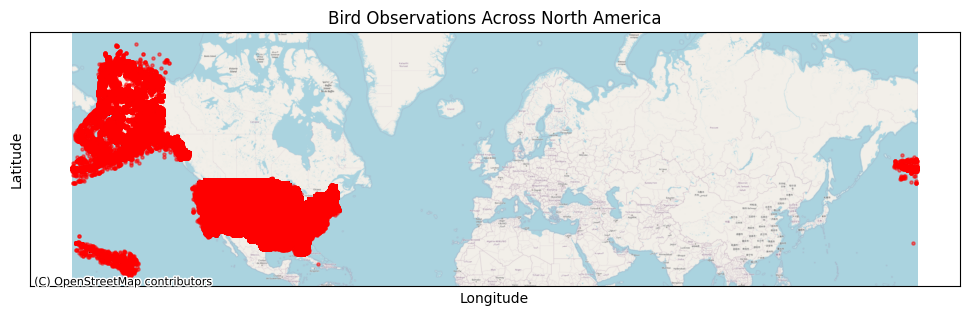

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Drop rows with missing latitude or longitude values
checklists = checklists.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    checklists,
    geometry=gpd.points_from_xy(checklists['LONGITUDE'], checklists['LATITUDE']),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# Convert CRS to Web Mercator for basemap compatibility
gdf = gdf.to_crs(epsg=3857)

# Plot with a basemap
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bird observation points
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5)

# Add a basemap of North America - using Openstreetmap instead of Stamen
# Stamen provider might have changed, causing the AttributeError.
# Update to a valid provider or use a different basemap source.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=4)

# Formatting
ax.set_title("Bird Observations Across North America")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xticks([])
ax.set_yticks([])

plt.show()